In [1]:
from shared.preface import *
import shared.functions as fct

## Ch. 0: Preliminary Investigations.

### 2D grid, center coord. pairs.

In [ ]:
def grid_2D(l, s):

    # 2D spatial grid, discretized.
    eps = s/10
    x, y = np.mgrid[-l:l+eps:s, -l:l+eps:s]

    # [x y] edge coordinate pairs of above grid.
    xy = np.mgrid[-l:l+eps:s, -l:l+eps:s].reshape(2,-1).T

    # Create center coord.-pairs.
    x_centers = (x[1:,:] + x[:-1,:])/2.
    y_centers = (y[:,1:] + y[:,:-1])/2.
    centers = np.array([x_centers[:,:-1], y_centers[:-1,:]])
    cent_coordPairs2D = centers.reshape(2,-1).T
    print('All coord. pairs 2D:\n', cent_coordPairs2D)
    # print('Coord pairs 2D shape:', cent_coordPairs2D.shape)

    return cent_coordPairs2D

limit_coarse, space_coarse = 1.5, 1.
cent_coordPairs2D = grid_2D(limit_coarse, space_coarse)

# Delete middle square.
cent_coordPairs2D = np.delete(cent_coordPairs2D, 4, axis=0)

# Create finegrained square.
limit_fine, space_fine = limit_coarse/2., space_coarse/2.
cent_coordPairs2D_fine = grid_2D(limit_fine, space_fine)

# Insert finegrained square.

### 3D grid, center coord. pairs.

In [ ]:
# 3D spatial grid, discretized.
x, y, z = np.mgrid[-1:1.1:1., -1:1.1:1., -1:1.1:1.]
# print(x[0,...], x.shape)

x_centers = (x[1:,...] + x[:-1,...])/2.
# print(x_centers, x_centers.shape)

y_centers = (y[:,1:,:] + y[:,:-1,:])/2.
# print(y_centers, y_centers.shape)

z_centers = (z[...,1:] + z[...,:-1])/2.
# print(z_centers, z_centers.shape)


# Create center coord.-pairs., truncate redundant points.
centers3D = np.array([
    x_centers[:,:-1,:-1], 
    y_centers[:-1,:,:-1], 
    z_centers[:-1,:-1,:]
])
# print(centers3D, centers3D.shape)

cent_coordPairs3D = centers3D.reshape(3,-1).T 
print(cent_coordPairs3D, cent_coordPairs3D.shape)

## Ch. 1: Milky Way-type halo and simple grid.

### 3D plot of the DM particles.

126187


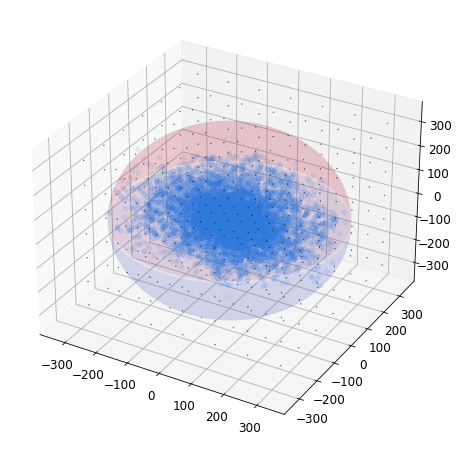

In [2]:
# Read DM particles.
fct.read_DM_positions_randomHalo(which_halos='halos', mass_select=12)

# Build grid around Milky Way.
MW_grid = fct.grid_3D(GRID_L, GRID_S) / kpc

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Read in DM particle positions.
DM_pos = np.load('sim_data/DM_positions_halos_M12.npy')
print(f'{len(DM_pos)}')
x_DM, y_DM, z_DM = DM_pos[:,0], DM_pos[:,1], DM_pos[:,2]
cut = 10
x, y, z = x_DM[1::cut], y_DM[1::cut], z_DM[1::cut]

ax.scatter(x, y, z, alpha=0.1, c='dodgerblue')

# Draw sphere around GC with radius=Rvir_MW.
rGC = Rvir_MW/kpc
uGC, vGC = np.mgrid[0:2 * np.pi:200j, 0:np.pi:100j]
xGC = rGC * np.cos(uGC) * np.sin(vGC)
yGC = rGC * np.sin(uGC) * np.sin(vGC)
zGC = rGC * np.cos(vGC)

xg, yg, zg = MW_grid[:,0], MW_grid[:,1], MW_grid[:,2] 
ax.scatter(xg, yg, zg, s=0.2, marker='x', color='black', alpha=0.5)


ax.plot_surface(
    xGC, yGC, zGC, alpha=0.1, 
    cmap=plt.cm.coolwarm, vmin=-1, vmax=1,# antialiased=False,
    rstride=1, cstride=1
)

plt.show()

### Calculate gravity in each cell.

In [3]:
DM_pos = np.load('sim_data/DM_positions_halos_M12.npy')

### Testing 1 cell with coords. at earth.
cell_id = 0
cell1 = np.array([8.5, 0, 0])*kpc

cell_vector = fct.cell_gravity(cell1, DM_pos, GRAV_RANGE, DM_SIM_MASS)
cell_vector /= (kpc/s**2)  
print(cell_vector)
print(np.sqrt(np.sum(cell_vector**2)))

#! this should be around same order of magnitude as in spher. symmetric setup.

[-1.47629727e-29 -1.71292523e-32  4.08050370e-31]
1.4768620802502691e-29


## Ch. 2: Broadcasting for cell_gravity.

In [4]:
fct.read_DM_positions_randomHalo(which_halos='halos', mass_select=12)
DM = np.load('sim_data/DM_positions_halos_M12.npy')[1::10]
grid = fct.grid_3D(GRID_L, GRID_S)

grid = np.expand_dims(grid, axis=1)

DM = np.expand_dims(DM, axis=0)
DM = np.repeat(DM, len(grid), axis=0)
print('DM positions array shape', DM.shape)

# diff = DM - grid
# print(diff.shape, (diff.nbytes)/1e6)

fct.cell_gravity_3D(grid, DM, GRAV_RANGE, DM_SIM_MASS)
dPsi_grid = np.load('CubeSpace/dPsi_grid_snapsnot_X.npy')
dPsi_grid /= (kpc/s**2) 
mags = np.sqrt(np.sum(dPsi_grid**2, axis=1))
print(mags[0])

DM positions array shape (343, 12619, 3)
5.3898472398479194e-33


## Ch. 3: Combined precalculations for all snapshots.

In [ ]:
from shared.preface import *
import shared.functions as fct

for i in range(12,37):
    snap_i = f'{i:04d}'
    print(snap_i)

    # 1. Read in DM positions of halo in snapshot.
    fct.read_DM_positions_randomHalo(
        which_halos='halos', mass_select=12, mass_range=1., snap_num=snap_i
        )
    DM_pos = np.load('sim_data/DM_positions_halos_M12.npy')[1::10]

    # 2. Build the spatial grid, depending on virial radius of halo, etc.
    cell_grid = fct.grid_3D(GRID_L, GRID_S)
    np.save(f'CubeSpace/cell_grid_snapsnot_{snap_i}', cell_grid)
    cell_grid = np.expand_dims(cell_grid, axis=1)

    # 2.5 Adjust arrays.
    DM_pos = np.expand_dims(DM_pos, axis=0)
    DM_pos = np.repeat(DM_pos, len(cell_grid), axis=0)

    # 3. Calculate derivatives of each cell.
    fct.cell_gravity_3D(
        cell_grid, DM_pos, GRAV_RANGE, DM_SIM_MASS, snap_num=snap_i
        )

snapshot_0012 is at redshift ~3.8.

**BUT** it contains no halo of mass_select=12 anymore.

**TODO:** start at snapshot_0036 (z~1e-16) and **trace same halo** backwards through the
snapshots.

Ugly fix for now: Extended mass_select window to search down to 1e11*Msun halos.
Then just pick random halo, will not be the same in all snapshots.

### Redshift z of each snapshot.

In [ ]:
zeds = np.zeros(25)
nums = []
for j, i in enumerate(range(12,37)):
    snap_i = f'{i:04d}'
    nums.append(snap_i)

    with h5py.File(f'{SIM_DATA}/snapshot_{snap_i}.hdf5') as snap:
        zeds[j] = snap['Cosmology'].attrs['Redshift'][0]

np.save(f'shared/ZEDS_SNAPSHOTS.npy', np.asarray(zeds))
np.save(f'shared/NUMS_SNAPSHOTS.npy', np.asarray(nums))

## Ch. 4: Better derivative grid structure. 

In [5]:
def cell_division(init_cc, DM_pos, parent_GRID_S, DM_lim, stable_cc):
    """
    Algorithm for fine-graining a given initial (uniform and rough) grid, which contains the coords of the center of the cells.
    Given a DM particle count threshold, the cells containing an amount of DM above this threshold will be divided into 8 new cells. This process is repeated until each cell is below the threshold. 
    The end result is a grid of cell (center) coordinates, which is adjusted to the given DM particle distribution.
    """

    # -------------- #
    # Preliminaries. #
    # -------------- #

    # Range within DM particles are "part of" the cell:
    # Circumscribed circle.
    # DM_range = parent_GRID_S/np.sqrt(2)
    # Inscribed circle.
    DM_range = parent_GRID_S/2.

    # Renaming the DM particle count limit to avoid confusion, when starting 
    # the recursive procedure again later (see end of function).
    DM_lim_copy = DM_lim

    # Keep track of how many iterations of the grid were necessary.
    cell_division.count += 1


    # --------------------------------------------------------------------- #
    # Determine which cells have DM above threshold and thus need division. #
    # --------------------------------------------------------------------- #

    # Center all DM positions w.r.t. center, for all cells.
    DM_cc = DM_pos - init_cc

    # Calculate distances of all DM to center, for all cells.
    DM_dist = np.sqrt(np.sum(DM_cc**2, axis=2))

    # Indices to order other arrays according to DM dist in ascending order.
    ind = DM_dist.argsort(axis=1)

    # Reshape these indices for compatibility.
    ind_3D = np.expand_dims(ind, axis=2)
    ind_3D = np.repeat(ind_3D, 3, axis=2)

    # Sort DM arrays according to DM distance with these indices.
    DM_cc_sort = np.take_along_axis(DM_cc, ind_3D, axis=1)
    DM_dist_sort = np.take_along_axis(DM_dist, ind, axis=1)

    # This array is a bit confusing: It has the shape (X,2) and contains pairs 
    # of indices, where the 1st entry is the cell number and the 2nd the index 
    # of a DM particle inside the given range for that cell. X then counts all 
    # DM particles inside range across all cells.
    DM_IDs = np.argwhere(DM_dist_sort <= DM_range)

    # Find the index unique to each cell, up to which the DM particles should
    # be kept, while the rest is outside range and no longer relevant.
    # Due to the method chosen, the last cell is not included and is attached 
    # seperately with np.vstack(...).
    row = DM_IDs.T[1]
    fw_diff = row[:-1] - row[1:]
    max_DM_rows_no_last_cell = np.argwhere(fw_diff.flatten() >= 0).flatten()
    max_DM_rows = np.vstack((DM_IDs[max_DM_rows_no_last_cell,:], DM_IDs[-1,:]))

    # Replace all entries beyond these indices (for each cell) with nan values.
    for i in range(len(init_cc)):

        if i in DM_IDs.T[0]:
            cell_ID = np.where(max_DM_rows[:,0] == i)[0][0]
            DM_cc_sort[i, max_DM_rows[cell_ID,1]+1:, :] = np.nan

        else:
            DM_cc_sort[i, ...] = np.nan

    # Drop "rows" common to all cells, which contain only nan values. This 
    # "maximum row" is determined by the highest value in the array, which 
    # contains the index of the row for each cell, beyond which the values are 
    # replaced by nan values.
    max_DM_rank = np.max(max_DM_rows[:,1])
    DM_cc_compact = np.delete(DM_cc_sort, np.s_[max_DM_rank+1:], axis=1)

    # Count the number of DM particles in each cell, after all the filtering.
    DM_count = np.count_nonzero(~np.isnan(DM_cc_compact[:,:,0]), axis=1)

    # Drop all cells containing an amount of DM below the given threshold, 
    # from the DM positions array...
    cell_cut_IDs = DM_count <= DM_lim_copy
    DM_cc_minimal = np.delete(DM_cc_compact, cell_cut_IDs, axis=0)


    #! If no cells are in need of division -> return final coords.
    if np.size(DM_cc_minimal, axis=0) == 0:

        if cell_division.count > 0:
            # The final iteration is a concatenation of the survival cells from 
            # the previous iteration and the newest sub8 cell coords...
            final_cc = np.concatenate((stable_cc, init_cc), axis=0)
            np.save('final_cc.npy', final_cc)
            return final_cc
        else:
            # ...or the initial grid itself, if it's fine-grained already.
            np.save('final_cc.npy', init_cc)
            return init_cc

    else:
        # ...and the initial cell coordinates grid. This array contains all 
        # cells (i.e. their coords. ), which need to be divided into 8 "child 
        # cells", hence the name "parent cells".
        parent_cc = np.delete(init_cc, cell_cut_IDs, axis=0)

        # "Reset" the DM coords, s.t. all DM positions are w.r.t. the origin of 
        # (0,0,0) again. This way we can easily center them on the new child 
        # cells again, as done in later steps below.
        DM_cc_reset = DM_cc_minimal + parent_cc


        # ------------------------------------------------ #
        # Replace each parent cell by the 8 new child cells.
        # ------------------------------------------------ #

        # Repeat each DM "column" 8 times. This will be the DM position array 
        # in the next iteration.
        DM_raw8 = np.repeat(DM_cc_reset, repeats=8, axis=0)

        # Create 8 new cells around origin of (0,0,0). The length and size of 
        # the new cells is determined by the previous length of the parent cell.
        sub8_GRID_S = parent_GRID_S/2.
        sub8_raw = fct.grid_3D(sub8_GRID_S, sub8_GRID_S)

        # Match dimensions of child-array(s) to parent-array(s).
        sub8 = np.expand_dims(sub8_raw, axis=0)
        sub8 = np.repeat(sub8, len(parent_cc), axis=0)

        # Center child-array(s) on parent cell coords.
        sub8_coords = sub8 - parent_cc

        # Reshape array to match repeated DM position array.
        sub8_coords = np.reshape(sub8_coords, (len(parent_cc)*8, 3))
        sub8_coords = np.expand_dims(sub8_coords, axis=1)

        # Delete all cells in initial cell coords array, corresponding to the 
        # cells in need of division, i.e. the parent cells.
        no_parents_cc = np.delete(init_cc, ~cell_cut_IDs, axis=0)

        if cell_division.count > 0:
            stable_cc_so_far = np.concatenate((stable_cc, no_parents_cc), axis=0)
        else:
            stable_cc_so_far = no_parents_cc

        #! Repeat the cell division process.
        cell_division(
            init_cc       = sub8_coords,
            DM_pos        = DM_raw8, 
            parent_GRID_S = sub8_GRID_S,  
            DM_lim        = DM_lim_copy,
            stable_cc     = stable_cc_so_far
        )



# Proper grid and DM positions.
grid = fct.grid_3D(GRID_L, GRID_S)
init_cc = np.expand_dims(grid, axis=1)
DM_raw = np.load('sim_data/DM_positions_halos_M12.npy')*kpc
DM_pos = np.expand_dims(DM_raw, axis=0)
DM_pos = np.repeat(DM_pos, len(init_cc), axis=0)

DM_lim = 500

cell_division.count = -1  # initialize the recursion counter
cell_division(init_cc, DM_pos, GRID_S, DM_lim, None)
final_cc = np.load('final_cc.npy')

print(init_cc.shape)
print(final_cc.shape)

print(f'Total cell division rounds: {cell_division.count}')

(343, 1, 3)
(546, 1, 3)
Total cell division rounds: 5


### Plotting the outcome after one iteration.

126187
125266


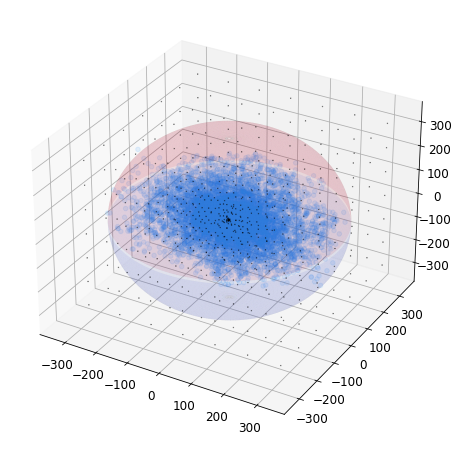

In [6]:
# Read DM particles.
fct.read_DM_positions_randomHalo(which_halos='halos', mass_select=12)

# Build grid around Milky Way.
new_grid = np.squeeze(final_cc, axis=1) / kpc

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Read in DM particle positions.
DM_pos = np.load('sim_data/DM_positions_halos_M12.npy')
print(f'{len(DM_pos)}')
x_DM, y_DM, z_DM = DM_pos[:,0], DM_pos[:,1], DM_pos[:,2]
cut = 10
x, y, z = x_DM[1::cut], y_DM[1::cut], z_DM[1::cut]

ax.scatter(x, y, z, alpha=0.1, c='dodgerblue')

# Draw sphere around GC with radius=Rvir_MW.
rGC = Rvir_MW/kpc
uGC, vGC = np.mgrid[0:2 * np.pi:200j, 0:np.pi:100j]
xGC = rGC * np.cos(uGC) * np.sin(vGC)
yGC = rGC * np.sin(uGC) * np.sin(vGC)
zGC = rGC * np.cos(vGC)

xg, yg, zg = new_grid[:,0], new_grid[:,1], new_grid[:,2] 
ax.scatter(xg, yg, zg, s=0.2, marker='x', color='black', alpha=0.5)


ax.plot_surface(
    xGC, yGC, zGC, alpha=0.1, 
    cmap=plt.cm.coolwarm, vmin=-1, vmax=1,# antialiased=False,
    rstride=1, cstride=1
)

# How many DM particles inside Virial Radius?
DM_dists = np.sqrt(np.sum(DM_pos**2, axis=1))
inside_VR = DM_pos[DM_dists <= rGC]
print(len(inside_VR))

plt.show()